# Classifying MNIST hand written characters with KCenters.jl
by: Eric S. Tellez

## Abstract
KCenters contains several agglomerative clustering algorithms and a classifier based on these algorithms, it is called KNC _Kernel based Nearest Centroid_. While it is based on the typical Nearest Centroid algorithm, it can use multiple algorithms to compute centroids (prototype generation and instance selection). Moreover, KNC can use several kernels functions to take advantage of different distributions of the datasets, and evenmore, it uses several heuristic to select as clusters or discard elements from clusters. Due to the explosion of possible approaches, `KCenters.jl` automatizes a model selection strategy through `AKNC`. The following tutorial shows how to construct a classifier for the well-known MNIST dataset using a vector modelling.

## Preparing the environment

The packages needed to run this tutorial can be installed uncommenting the third line of the next cell. Note that
we install KCenters.jl directly from the github repository to ensure we are working with the last available version.

In [1]:
using Pkg
pkg"activate ."
#pkg"add https://github.com/sadit/KCenters.jl SimilaritySearch MLDatasets MLDataUtils LinearAlgebra Images StatsBase JSON"
using KCenters, SimilaritySearch, MLDatasets, MLDataUtils, LinearAlgebra, Images, StatsBase, JSON

Activating environment at `~/Research/KCenters.jl/tutorials/Project.toml`


## Loading the dataset

The dataset is loaded from MLDatasets and prepared just scaling each vector to have unitary norm; the later helps to improve the final results by a couple of percentual points (it is possible to observe just toggling comments of line 8 and 9 at the `normalize_vector` function).

In [2]:
"""
    normalize_vector(X, i)

Converts an image X into a vector of 784 dimensions and normalizes it
"""
function normalize_vector(X, i)
    v = @view X[:, :, i]
    normalize!(Float32.(reshape(v, 784)))
    #Float32.(reshape(v, 784))
end

"""
    convertimage(x)

Converts a vector to an image for displaying; it scales pixels because the vector has unitary norm.
"""
convertimage(x) = Gray.(8*(reshape(x, (28, 28))'))

"""
    load_data()

Loads the MNIST benchmark and converts the dataset to individual vectors; labels are also encoded as integers
"""
function load_data()
    train_X, train_y = MNIST.traindata()
    test_X, test_y = MNIST.testdata()
    le = labelenc(train_y)
    
    # KCenters work with collections of vectors more than concatenation of them
    X1 = [normalize_vector(train_X, c) for c in 1:size(train_X, 3)]
    X2 = [normalize_vector(test_X, c) for c in 1:size(test_X, 3)]

    X1, label2ind.(train_y, le), X2, label2ind.(test_y, le), le
end


load_data

## Selecting a good model for MNIST

The `run_test` function selects a competitive model calling `search_params` function; the optimization process is controlled by a number of parameters, they are mostly used to trade between optimization time and quality. The search space of models are defined using several keyword parameters; please revise `autonearestcentroids.jl` to see parameters (they will be explained here soon).


In [10]:
JSON.lower(f::Function) = string(f)

function run_test(train_X, train_y, test_X, test_y; verbose=true, kwargs...)
    O = []
    P = nothing
    best_list = search_params(AKNC, train_X, train_y, 32,
        # search hyper-parameters
        bsize=8, mutation_bsize=3, ssize=8, folds=0.7, search_maxiters=8,
        score=:accuracy, tol=0.01, verbose=verbose,
        # defining the configuration space
        kernel=[relu_kernel, direct_kernel];
        kwargs...)
    
    println("== The performance on the selected models is as follows:")
    for (i, c) in enumerate(best_list)
        println(i, ", score=", c[2], ", config=", JSON.json(c[1]))
    end

    config, score = best_list[1]
    model = fit(config, train_X, train_y, verbose=verbose)
    ypred = predict(model, test_X)
    s = scores(test_y, ypred)
    println("== The performance on the gold standard is as follows:")
    println(JSON.json(s, 2))
    model, s
end


run_test (generic function with 1 method)

### Running a Rocchio-like classifier
The Rocchio classifier is a Nearest Centroid, mainly used for text classification where each centroid represents one class and this centroid is computed with all documents having the same class. Here, we use these idea to produce a simple and fast construction model specifying the parameter `ncenters=[0]`. Notice that search-space's parameters are mostly defined as lists of possible values. We also explicitly give what kind of distances can be used in our modelling to measure similarity.


In [11]:
train_X, train_y, test_X, test_y, le = load_data()
run_test(train_X, train_y, test_X, test_y; ncenters=[0], dist=[l2_distance, cosine_distance]);

== The performance on the selected models is as follows:
1, score=0.816, config={"kernel":"direct_kernel","dist":"l2_distance","centroid":"mean","k":1,"ncenters":0,"maxiters":0,"recall":1.0,"initial_clusters":"rand","split_entropy":0.0,"minimum_elements_per_centroid":1}
2, score=0.7803888888888889, config={"kernel":"relu_kernel","dist":"l2_distance","centroid":"mean","k":1,"ncenters":0,"maxiters":0,"recall":1.0,"initial_clusters":"rand","split_entropy":0.0,"minimum_elements_per_centroid":1}
3, score=0.7624444444444445, config={"kernel":"direct_kernel","dist":"cosine_distance","centroid":"mean","k":1,"ncenters":0,"maxiters":0,"recall":1.0,"initial_clusters":"rand","split_entropy":0.0,"minimum_elements_per_centroid":1}
4, score=0.7568333333333334, config={"kernel":"relu_kernel","dist":"cosine_distance","centroid":"mean","k":1,"ncenters":0,"maxiters":0,"recall":1.0,"initial_clusters":"rand","split_entropy":0.0,"minimum_elements_per_centroid":1}


iteration 1 finished
generating 8 configurations using top 8 configurations, starting with 4)
[0.816, 0.7803888888888889, 0.7624444444444445, 0.7568333333333334]
AKNC_Config(KCenters.direct_kernel, SimilaritySearch.l2_distance, Statistics.mean, 1, 0, 0, 1.0, :rand, 0.0, 1) => 0.816
finished with 4
iteration 2 finished
stopping on iteration 2 due to a possible convergence (0.816 ≃ 0.816, tol: 0.01)


== The performance on the gold standard is as follows:
{
  "micro_f1": 0.8223,
  "precision": 0.8223,
  "recall": 0.8223,
  "macro_recall": 0.8196808470834271,
  "macro_f1": 0.8199411066105006,
  "accuracy": 0.8223,
  "class_f1": {
    "7": 0.7802400738688828,
    "9": 0.8724489795918366,
    "4": 0.9033376679670568,
    "10": 0.7546978161503302,
    "2": 0.8966202783300199,
    "3": 0.8110831234256928,
    "5": 0.7709551656920078,
    "8": 0.8671182907764461,
    "6": 0.8160804020100503,
    "1": 0.726829268292683
  },
  "class_precision": {
    "7": 0.7309688581314879,
    "9": 0.9173819742489271,
    "4": 0.8890784982935154,
    "10": 0.7467336683417085,
    "2": 0.874031007751938,
    "3": 0.80259222333001,
    "5": 0.7583892617449665,
    "8": 0.8657648283038502,
    "6": 0.8475991649269311,
    "1": 0.7967914438502673
  },
  "class_recall": {
    "7": 0.8366336633663366,
    "9": 0.8317120622568094,
    "4": 0.9180616740088106,
    "10": 0.7628336755646817,
    "2": 0.92040816326

After the model selection stage finished, the functions use that specification to create a model over the whole training set
and test it with the gold-standard.

### Model selection on a more sophisticated space
Looking for increasing the performance we can increase the number of centers, and apply other heuristics for
centroid constructions. The following call bounds several configuration parameters, you can explore just removing the parameter or specifying more values to explore.
Notice that this search can be computationally expensive, and `search_params` use `Distributed.@spawn` calls for model evaluation so you can add workers using `Distributed` or `ClusterManager` packages to speed up the optimization.

In [4]:
model, s = run_test(train_X, train_y, test_X, test_y, verbose=false, ncenters=[100], dist=[l2_distance], k=[1], split_entropy=[0.3], initial_clusters=[:fft], minimum_elements_per_centroid=[3], maxiters=[3])

1, score=0.9348333333333333, config={"kernel":"direct_kernel","dist":"l2_distance","centroid":"mean","k":1,"ncenters":100,"maxiters":3,"recall":1.0,"initial_clusters":"fft","split_entropy":0.3,"minimum_elements_per_centroid":3}
2, score=0.36294444444444446, config={"kernel":"relu_kernel","dist":"l2_distance","centroid":"mean","k":1,"ncenters":100,"maxiters":3,"recall":1.0,"initial_clusters":"fft","split_entropy":0.3,"minimum_elements_per_centroid":3}
{
  "micro_f1": 0.9406,
  "precision": 0.9406,
  "recall": 0.9406,
  "macro_recall": 0.9401991791134657,
  "macro_f1": 0.9400434257395229,
  "accuracy": 0.9406,
  "class_f1": {
    "7": 0.9229984701682815,
    "9": 0.939231891103549,
    "4": 0.9759720401922238,
    "10": 0.9243027888446216,
    "2": 0.9707366296670031,
    "3": 0.9365652398143374,
    "5": 0.8945273631840797,
    "8": 0.9625390218522374,
    "6": 0.9456681350954479,
    "1": 0.927892677473449
  },
  "class_precision": {
    "7": 0.9516298633017876,
    "9": 0.938775510204

(AKNC{Array{Float32,1}}(KNC{Array{Float32,1}}(Array{Float32,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0037758232, 0.0025303948, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0017770283, 0.0026298445, 0.0022759342, 0.001434571, 0.003081862, 0.00067492924, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 

## Conclusions
Now let us explore what kind of centers we computed, these are the character prototypes used to perform the classication.

the label 5 is represented by 40 centroids

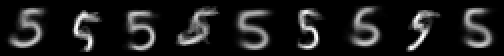

the label 0 is represented by 23 centroids

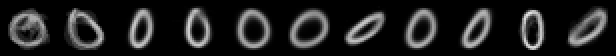

the label 4 is represented by 29 centroids

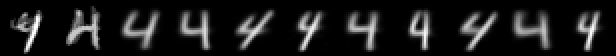

the label 1 is represented by 15 centroids

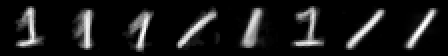

the label 9 is represented by 37 centroids

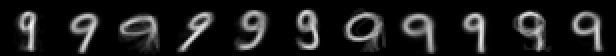

the label 2 is represented by 32 centroids

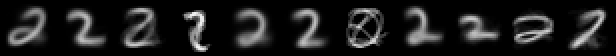

the label 3 is represented by 40 centroids

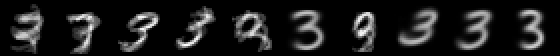

the label 6 is represented by 23 centroids

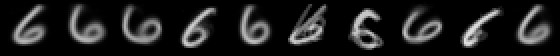

the label 7 is represented by 28 centroids

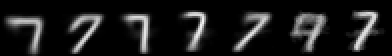

the label 8 is represented by 47 centroids

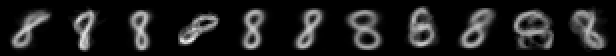

In [16]:
for (ind, lst) in sort(labelmap(model.nc.class_map))
    label = ind2label.(ind, le)
    display("text/html", "the label $label is represented by $(length(lst)) centroids")
    L = unique(rand(lst, 12))
    hcat(convertimage.(model.nc.centers[L])...) |> display
end


We can see that there exists several well defined sub-classes of each digit; some few of these examples are difficult to read, which suggest that they were produced by wrongly labeled items or by very different forms wrongly clustered. While this is a problem, we must remember that 60'000 items were summarized in just a few hundred centroids, such that a some encoding difficulties can be expected. Also notice that there is no image manipulation or feature identification; the whole image was used to represent an element.